<a href="https://colab.research.google.com/github/kmkolasinski/keras_detection/blob/master/notebooks/fpn_builder_svhn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip uninstall -y tensorflow
! pip install -q tf-nightly==2.2.0.dev20200428
! pip install -q --extra-index-url=https://test.pypi.org/simple/ tensorflow-model-optimization==0.3.0.dev6

     |████████████████████████████████| 520.0MB 31kB/s 
     |████████████████████████████████| 2.9MB 46.6MB/s 
     |████████████████████████████████| 460kB 57.6MB/s 


In [4]:
pip install --upgrade git+https://github.com/kmkolasinski/keras_detection.git

  Cloning https://github.com/kmkolasinski/keras_detection.git to /tmp/pip-req-build-b17abtfd
  Running command git clone -q https://github.com/kmkolasinski/keras_detection.git /tmp/pip-req-build-b17abtfd
     |████████████████████████████████| 17.3MB 211kB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 952kB 50.7MB/s 
  Created wheel for keras-detection: filename=keras_detection-0.1-cp36-none-any.whl size=69748 sha256=c718bff10931279e585bcf35a59c6a9f321f14027ae77913e029541ba28e3cbd
  Stored in directory: /tmp/pip-ephem-wheel-cache-fi89n1zk/wheels/9c/23/23/2d3299a84b3beda7addbe5f17af1aa74b0e15fd87214803132
Successfully built keras-detection
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Fo

In [1]:
# test installation
import keras_detection
import tensorflow as tf
tf.__version__

'2.2.0-dev20200428'

# Download dataset
Download nad unpack SVHN dataset to datasets/SVHN/[train|test] folder

Download RAW data

In [2]:
!wget http://ufldl.stanford.edu/housenumbers/train.tar.gz
!wget http://ufldl.stanford.edu/housenumbers/test.tar.gz

--2020-04-28 17:07:25--  http://ufldl.stanford.edu/housenumbers/train.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404141560 (385M) [application/x-gzip]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>] 385.42M  86.1MB/s    in 4.5s    

2020-04-28 17:07:30 (85.8 MB/s) - ‘train.tar.gz’ saved [404141560/404141560]

--2020-04-28 17:07:31--  http://ufldl.stanford.edu/housenumbers/test.tar.gz
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276555967 (264M) [application/x-gzip]
Saving to: ‘test.tar.gz’

test.tar.gz         100%[===================>] 263.74M  97.1MB/s    in 2.7s    

2020-04-28 17:07:34 (97.1 MB/s) - ‘test.tar.gz’ saved [276555967/2

In [0]:
!tar -xf train.tar.gz
!tar -xf test.tar.gz

# Load dataset 
Prepare and load SVHN dataset as tfrecrods, this will take few minutes


In [4]:
from keras_detection.datasets.svhn.read_svhm_map import load_dataset

train_raw_dataset, num_train_examples = load_dataset('train')
test_raw_dataset, num_test_examples = load_dataset('test')

Parsing train/digitStruct.mat, this may take a while


/usr/local/lib/python3.6/dist-packages/keras_detection/datasets/svhn/read_svhm_map.py:144: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))
/usr/local/lib/python3.6/dist-packages/keras_detection/datasets/svhn/read_svhm_map.py:138: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return "".join([chr(c[0]) for c in self.inf[self.digit_struct_name[n][0]].value])
/usr/local/lib/python3.6/dist-packages/keras_detection/datasets/svhn/read_svhm_map.py:147: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  attr = [attr.value[0][0]]
  0%|          | 127/33402 [00:00<00:26, 1265.34it/s]

Loaded annotations for 33402 images
Loading images ... 


100%|██████████| 33402/33402 [00:01<00:00, 20724.08it/s]


Saving dataset to: train/train.pkl
Parsing test/digitStruct.mat, this may take a while


  1%|          | 89/13068 [00:00<00:14, 889.68it/s]

Loaded annotations for 13068 images
Loading images ... 


100%|██████████| 13068/13068 [00:00<00:00, 22796.79it/s]


Saving dataset to: test/test.pkl


In [5]:
train_raw_dataset

<FlatMapDataset shapes: {features: {image: (None, None, 3)}, labels: {boxes: (None, 4), labels: (None,), weights: (None,)}}, types: {features: {image: tf.uint8}, labels: {boxes: tf.float32, labels: tf.int64, weights: tf.float32}}>

In [6]:
num_train_examples, num_test_examples

(33402, 13068)

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
keras = tf.keras

In [8]:
# disable tensorflow duplicated logs
from tensorflow.python.platform.tf_logging import _logger
_logger.handlers.pop(0)

<StreamHandler stdout (NOTSET)>

In [9]:
train_raw_dataset

<FlatMapDataset shapes: {features: {image: (None, None, 3)}, labels: {boxes: (None, 4), labels: (None,), weights: (None,)}}, types: {features: {image: tf.uint8}, labels: {boxes: tf.float32, labels: tf.int64, weights: tf.float32}}>

# Define model input and dataset parametres

In [0]:
num_classes = 10  # SVHN digits
image_dim = 128
batch_size = 64
num_epochs = -1
num_parallel_calls = tf.data.experimental.AUTOTUNE
num_test_steps = num_test_examples // batch_size

In [0]:
from keras_detection.datasets.datasets_ops import prepare_dataset

In [0]:
train_dataset = prepare_dataset(
    dataset=train_raw_dataset, 
    augmentation_fn=None,
    model_image_size=(image_dim, image_dim),
    batch_size=batch_size,
    num_epochs=num_epochs,
    shuffle_buffer_size=1024,
    prefetch_buffer_size=8,
    num_parallel_calls=num_parallel_calls
)

test_dataset = prepare_dataset(
    dataset=test_raw_dataset, 
    augmentation_fn=None,
    model_image_size=(image_dim, image_dim),
    batch_size=batch_size,
    num_epochs=1,
    shuffle_buffer_size=None,
    prefetch_buffer_size=2,
    num_parallel_calls=num_parallel_calls
)

# Define model

In [0]:
import keras_detection.backbones.mobilenetv2_customized as mobilenet
import keras_detection.tasks.standard_tasks as standard_tasks
import keras_detection.models.fpn_builder as fpn_builder
import keras_detection.models.utils as kd_utils
from keras_detection.utils import plotting

In [14]:
backbone = mobilenet.MobileNetV2Backbone(
    input_shape=[image_dim, image_dim, 3],
    alpha=1.0, min_fm_size=10, weights='imagenet'
)

tasks = [
    # predicts objectnes score for each anchor
    standard_tasks.get_objectness_task(label_smoothing=0.02, obj_class="center_ignore_margin"),
    # predicts [height, with, y, x ] location of the box
    standard_tasks.get_box_shape_task("box_shape"),
    # predicts [num_classes] for each anchor (focal loss is not supported yet)
    standard_tasks.get_multiclass_task(num_classes, fl_gamma=0.0, label_smoothing=0, activation='softmax'),
]

9412608/9406464 [==============================] - 1s 0us/step


Skipping loading of weights for layer Conv_1 due to mismatch in shape ((1, 1, 320, 320) vs (1280, 320, 1, 1)).
Skipping loading of weights for layer Conv_1_bn due to mismatch in shape ((320,) vs (1280,)).
Skipping loading of weights for layer Conv_1_bn due to mismatch in shape ((320,) vs (1280,)).
Skipping loading of weights for layer Conv_1_bn due to mismatch in shape ((320,) vs (1280,)).
Skipping loading of weights for layer Conv_1_bn due to mismatch in shape ((320,) vs (1280,)).


In [0]:
builder = fpn_builder.FPNBuilder(backbone = backbone, tasks = tasks)
model = builder.build(batch_size=None)

In [16]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 128, 128, 3) 0           image[0][0]                      
__________________________________________________________________________________________________
mobilenetv2_1.00_128 (Model)    (None, 16, 16, 320)  1566848     tf_op_layer_RealDiv[0][0]        
__________________________________________________________________________________________________
model (Model)                   (None, 16, 16, 1)    184705      mobilenetv2_1.00_128[0][0]       
____________________________________________________________________________________________

# Train model

In [0]:
prepared_train_dataset = train_dataset.map(builder.get_build_training_targets_fn())

In [18]:
# Check the content of targets
prepared_train_dataset

<MapDataset shapes: ({image: (64, 128, 128, 3)}, {fm16x16/objectness: (64, 16, 16, 2), fm16x16/box_shape: (64, 16, 16, 5), fm16x16/classes: (64, 16, 16, 12)}), types: ({image: tf.float32}, {fm16x16/objectness: tf.float32, fm16x16/box_shape: tf.float32, fm16x16/classes: tf.float32})>

## Check targets
Visualize target boxes, target objectness and other 

In [0]:
features, labels = next(iter(prepared_train_dataset))

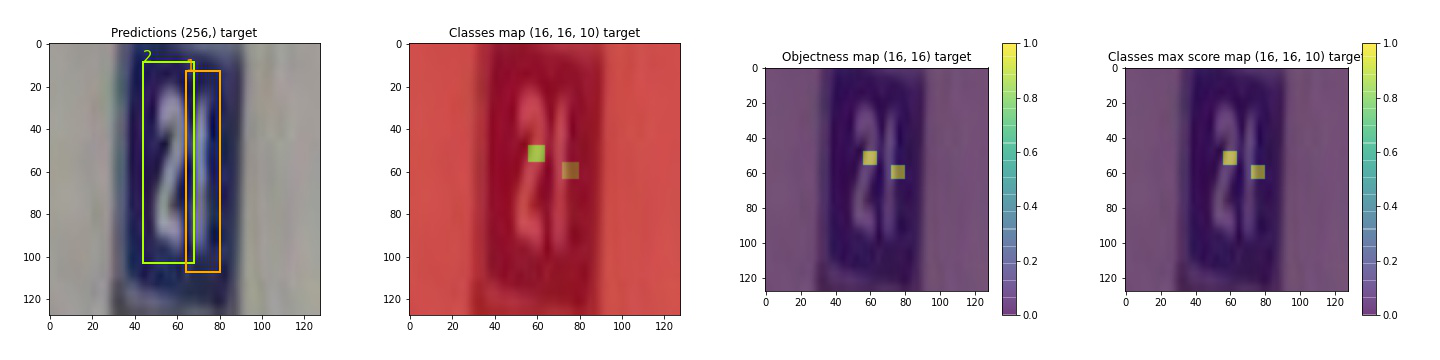

In [22]:
fm = "fm16x16"

targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
targets = builder.predictions_to_dict(targets, postprocess=True)

idx = 2
target=dict(
    objectness=targets[f'{fm}/objectness'][idx],
    boxes_shape_map=targets[f'{fm}/box_shape'][idx],
    classes_map=targets[f'{fm}/classes'][idx],
)

render = plotting.draw_compares(    
    target=target,
    predicted=None,
    all_targets=True,
    draw_fns=[
        plotting.draw_boxes, 
        plotting.draw_classes_map,
        plotting.draw_objectness_map,
        plotting.draw_classes_max_score_map,
    ],
    image=features['image'][idx] / 255,
    score_threshold=0.2, 
)
render

## Run training model

In [0]:
l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=model)
model.add_loss(l2_reg_fn)

In [24]:
model.losses, l2_reg_fn()

([<tf.Tensor: shape=(), dtype=float32, numpy=0.17845164>],
 <tf.Tensor: shape=(), dtype=float32, numpy=0.17845164>)

In [25]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=5, steps_per_epoch=500)

Epoch 1/10
  2/500 [..............................] - ETA: 1:19 - loss: 4.6617 - fm16x16/objectness_loss: 0.6785 - fm16x16/box_shape_loss: 0.1129 - fm16x16/classes_loss: 2.6762 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.0109 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.7806 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.4433 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.3538 - fm16x16/classes_MulticlassAccuracyMetric: 0.0605

Callbacks method `on_train_batch_end` is slow compared to the batch time. Check your callbacks.


500/500 [==============================] - 151s 301ms/step - loss: 0.5823 - fm16x16/objectness_loss: 0.0617 - fm16x16/box_shape_loss: 0.0211 - fm16x16/classes_loss: 0.1376 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1236 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9117 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.6978 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0536 - fm16x16/classes_MulticlassAccuracyMetric: 0.1646
Epoch 2/10
500/500 [==============================] - 151s 301ms/step - loss: 0.3591 - fm16x16/objectness_loss: 0.0258 - fm16x16/box_shape_loss: 0.0151 - fm16x16/classes_loss: 0.0368 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1638 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9520 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8348 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0326 - fm16x16/classes_MulticlassAccuracyMetric: 0.3085
Epoch 3/10
500/500 [==============================] - 150s 300ms/step - loss: 0.3139 - fm16x16/ob

In [26]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_2=0.99)
model.compile(optimizer, **builder.get_model_compile_args())
model.fit(prepared_train_dataset, epochs=2, steps_per_epoch=500)

Epoch 1/2
  2/500 [..............................] - ETA: 2:29 - loss: 0.3596 - fm16x16/objectness_loss: 0.0296 - fm16x16/box_shape_loss: 0.0161 - fm16x16/classes_loss: 0.0333 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1659 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9290 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8186 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0314 - fm16x16/classes_MulticlassAccuracyMetric: 0.4720

Callbacks method `on_train_batch_end` is slow compared to the batch time. Check your callbacks.


500/500 [==============================] - 151s 302ms/step - loss: 0.3289 - fm16x16/objectness_loss: 0.0233 - fm16x16/box_shape_loss: 0.0139 - fm16x16/classes_loss: 0.0305 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1647 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9589 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8478 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0311 - fm16x16/classes_MulticlassAccuracyMetric: 0.5019
Epoch 2/2
500/500 [==============================] - 151s 302ms/step - loss: 0.3257 - fm16x16/objectness_loss: 0.0224 - fm16x16/box_shape_loss: 0.0137 - fm16x16/classes_loss: 0.0298 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1677 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9605 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8537 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0307 - fm16x16/classes_MulticlassAccuracyMetric: 0.5167


There will be a gap between training metrics and evaluation metrics, which comes from the presence of BatchNorm. There will be also a gap between train and test datasets which signalizes the overfitting. 

In [27]:
builder.evaluate_model(model, test_dataset, num_test_steps)

5 out of the last 5 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f07f17e8048> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please  define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
6 out of the last 6 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f07f1551d08> triggered tf.function retracing. Tracing is expensive and the exc

  2/204 [..............................] - ETA: 15s - loss: 0.3625 - fm16x16/objectness_loss: 0.0405 - fm16x16/box_shape_loss: 0.0152 - fm16x16/classes_loss: 0.0331 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1740 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.8411 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.6220 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0189 - fm16x16/classes_MulticlassAccuracyMetric: 0.3236

Callbacks method `on_test_batch_end` is slow compared to the batch time. Check your callbacks.


204/204 [==============================] - 16s 80ms/step - loss: 0.3650 - fm16x16/objectness_loss: 0.0396 - fm16x16/box_shape_loss: 0.0155 - fm16x16/classes_loss: 0.0337 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1861 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.8399 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.6267 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0193 - fm16x16/classes_MulticlassAccuracyMetric: 0.3742


[0.3650127947330475,
 0.03959690034389496,
 0.015488848090171814,
 0.03371812030673027,
 0.18606902658939362,
 0.8399138450622559,
 0.6266849040985107,
 0.019327765330672264,
 0.37420856952667236]

In [28]:
builder.evaluate_model(model, train_dataset, num_test_steps)

7 out of the last 7 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f07ecac9ea0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please  define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
8 out of the last 8 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f07ecac9c80> triggered tf.function retracing. Tracing is expensive and the exc

  2/204 [..............................] - ETA: 15s - loss: 0.3453 - fm16x16/objectness_loss: 0.0293 - fm16x16/box_shape_loss: 0.0146 - fm16x16/classes_loss: 0.0329 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1906 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9251 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.6982 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0222 - fm16x16/classes_MulticlassAccuracyMetric: 0.4753

Callbacks method `on_test_batch_end` is slow compared to the batch time. Check your callbacks.


204/204 [==============================] - 17s 81ms/step - loss: 0.3474 - fm16x16/objectness_loss: 0.0293 - fm16x16/box_shape_loss: 0.0149 - fm16x16/classes_loss: 0.0326 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1895 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9166 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.7051 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0229 - fm16x16/classes_MulticlassAccuracyMetric: 0.4807


[0.3474366068840027,
 0.029315924271941185,
 0.014875234104692936,
 0.03255897015333176,
 0.189546138048172,
 0.9166320562362671,
 0.7050628662109375,
 0.02287696860730648,
 0.4807073175907135]

In [0]:
!mkdir --parents models

In [0]:
model.save_weights("models/non-quantized-model.h5")

In [0]:
model.load_weights("models/non-quantized-model.h5")

# Test trained model

In [32]:
builder.evaluate_model(model, test_dataset, num_test_steps)

10 out of the last 10 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f07ec27ef28> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please  define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
11 out of the last 11 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f07ec27ec80> triggered tf.function retracing. Tracing is expensive and the

  2/204 [..............................] - ETA: 16s - loss: 0.3625 - fm16x16/objectness_loss: 0.0405 - fm16x16/box_shape_loss: 0.0152 - fm16x16/classes_loss: 0.0331 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1740 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.8411 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.6220 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0189 - fm16x16/classes_MulticlassAccuracyMetric: 0.3236

Callbacks method `on_test_batch_end` is slow compared to the batch time. Check your callbacks.


204/204 [==============================] - 17s 81ms/step - loss: 0.3650 - fm16x16/objectness_loss: 0.0396 - fm16x16/box_shape_loss: 0.0155 - fm16x16/classes_loss: 0.0337 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1861 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.8399 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.6267 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0193 - fm16x16/classes_MulticlassAccuracyMetric: 0.3742


[0.3650127947330475,
 0.03959690034389496,
 0.015488848090171814,
 0.03371812030673027,
 0.18606902658939362,
 0.8399138450622559,
 0.6266849040985107,
 0.019327765330672264,
 0.37420856952667236]

In [33]:
prepared_test_dataset = test_dataset.map(builder.get_build_training_targets_fn())
dataset_iterator = iter(prepared_test_dataset)

11 out of the last 11 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f079015d7b8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please  define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
11 out of the last 11 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f079015dea0> triggered tf.function retracing. Tracing is expensive and the

In [0]:
features, labels = next(dataset_iterator)
predictions = model.predict(features)
predictions = builder.predictions_to_dict(predictions, postprocess=True)

In [35]:
builder.get_outputs_names()

['fm16x16/objectness', 'fm16x16/box_shape', 'fm16x16/classes']

In [0]:
fm = "fm16x16"
targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
targets = builder.predictions_to_dict(targets, postprocess=True)

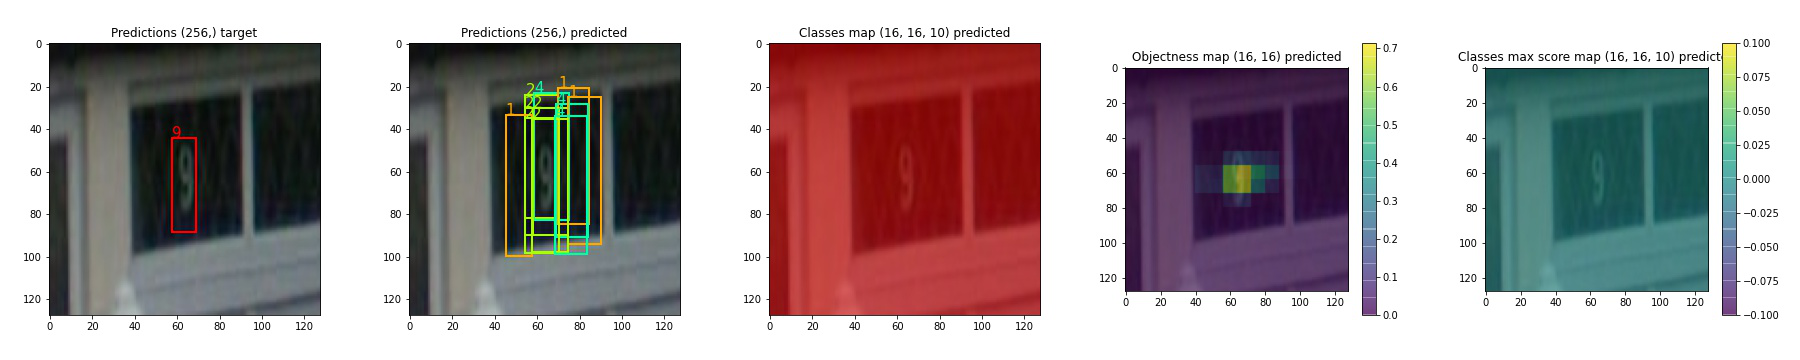

In [42]:
# select index of image in batch
idx = 4
target=dict(
    objectness=targets[f'{fm}/objectness'][idx],
    boxes_shape_map=targets[f'{fm}/box_shape'][idx],
    classes_map=targets[f'{fm}/classes'][idx],
)

predicted=dict(
    objectness=predictions[f'{fm}/objectness'][idx],
    boxes_shape_map=predictions[f'{fm}/box_shape'][idx],
    classes_map=predictions[f'{fm}/classes'][idx],
)

render = plotting.draw_compares(    
    target=target,
    predicted=predicted,
    draw_fns=[
        plotting.draw_boxes, 
        plotting.draw_classes_map,
        plotting.draw_objectness_map,
        plotting.draw_classes_max_score_map,
    ],
    image=features['image'][idx] / 255,
    score_threshold=0.1,
)
render

# Quantize model
Convert model to quantized version and initialize its weights with previosuly pretrained model

In [0]:
quantized_model = builder.build_quantized(
    batch_size=None, 
    non_quantized_model_weights="models/non-quantized-model.h5"
)

In [44]:
quantized_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv_2 (TensorFl [(None, 128, 128, 3) 0           image[0][0]                      
__________________________________________________________________________________________________
mobilenetv2_1.00_128 (Model)    (None, 16, 16, 320)  1581907     tf_op_layer_RealDiv_2[0][0]      
__________________________________________________________________________________________________
model_4 (Model)                 (None, 16, 16, 1)    184846      mobilenetv2_1.00_128[0][0]       
____________________________________________________________________________________________

In [45]:
# test metrics after quantization, they should be much worse
builder.evaluate_model(quantized_model, test_dataset, num_test_steps)

11 out of the last 11 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f066f401598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please  define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
11 out of the last 11 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f066f401c80> triggered tf.function retracing. Tracing is expensive and the

  2/204 [..............................] - ETA: 24s - loss: 2.6657 - fm16x16/objectness_loss: 0.0568 - fm16x16/box_shape_loss: 0.0212 - fm16x16/classes_loss: 2.3973 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1765 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.7474 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.4765 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0182 - fm16x16/classes_MulticlassAccuracyMetric: 0.0508

Callbacks method `on_test_batch_end` is slow compared to the batch time. Check your callbacks.


204/204 [==============================] - 38s 187ms/step - loss: 2.7089 - fm16x16/objectness_loss: 0.0578 - fm16x16/box_shape_loss: 0.0254 - fm16x16/classes_loss: 2.3970 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1851 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.7157 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.4713 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0186 - fm16x16/classes_MulticlassAccuracyMetric: 0.0552


[2.7089242935180664,
 0.05776938423514366,
 0.025418566539883614,
 2.396967649459839,
 0.18511347472667694,
 0.7156603932380676,
 0.47127535939216614,
 0.018602922558784485,
 0.05517895892262459]

# Train quantized model

In [46]:
prepared_train_dataset = train_dataset.map(builder.get_build_training_targets_fn())

11 out of the last 11 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f066ee71378> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please  define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
11 out of the last 11 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f066ee71a60> triggered tf.function retracing. Tracing is expensive and the

In [0]:
l2_reg_fn = kd_utils.get_l2_loss_fn(l2_reg=1e-5, model=quantized_model)
quantized_model.add_loss(l2_reg_fn)

In [48]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=6, steps_per_epoch=500)
quantized_model.save_weights("models/quantized-model.h5")

Epoch 1/6
500/500 [==============================] - 330s 660ms/step - loss: 0.5783 - fm16x16/objectness_loss: 0.0274 - fm16x16/box_shape_loss: 0.0248 - fm16x16/classes_loss: 0.1814 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1686 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9465 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8333 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0310 - fm16x16/classes_MulticlassAccuracyMetric: 0.2349
Epoch 2/6
500/500 [==============================] - 329s 658ms/step - loss: 0.2917 - fm16x16/objectness_loss: 0.0204 - fm16x16/box_shape_loss: 0.0137 - fm16x16/classes_loss: 0.0339 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1797 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9656 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8690 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0288 - fm16x16/classes_MulticlassAccuracyMetric: 0.3702
Epoch 3/6
500/500 [==============================] - 329s 659ms/step - loss: 0.2672 - fm

In [0]:
quantized_model.load_weights("models/quantized-model.h5")

In [50]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_2=0.995)
quantized_model.compile(optimizer, **builder.get_model_compile_args())
quantized_model.fit(prepared_train_dataset, epochs=10, steps_per_epoch=500)
quantized_model.save_weights("models/quantized-model.h5")

Epoch 1/10
500/500 [==============================] - 333s 665ms/step - loss: 0.2202 - fm16x16/objectness_loss: 0.0168 - fm16x16/box_shape_loss: 0.0119 - fm16x16/classes_loss: 0.0276 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1903 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9747 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8917 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0273 - fm16x16/classes_MulticlassAccuracyMetric: 0.6307
Epoch 2/10
500/500 [==============================] - 333s 667ms/step - loss: 0.2175 - fm16x16/objectness_loss: 0.0163 - fm16x16/box_shape_loss: 0.0118 - fm16x16/classes_loss: 0.0274 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1938 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9755 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8953 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0271 - fm16x16/classes_MulticlassAccuracyMetric: 0.6372
Epoch 3/10
500/500 [==============================] - 333s 666ms/step - loss: 0.2166 -

KeyboardInterrupt: ignored

In [0]:
quantized_model.save_weights("models/quantized-model.h5")

In [0]:
quantized_model.load_weights("models/quantized-model.h5")

## Evalute quantized model

In [52]:
builder.evaluate_model(quantized_model, test_dataset, num_test_steps)

11 out of the last 11 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f05b65048c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please  define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
11 out of the last 11 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f05b6504bf8> triggered tf.function retracing. Tracing is expensive and the

  2/204 [..............................] - ETA: 28s - loss: 0.2329 - fm16x16/objectness_loss: 0.0254 - fm16x16/box_shape_loss: 0.0122 - fm16x16/classes_loss: 0.0321 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1806 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9232 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8396 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0233 - fm16x16/classes_MulticlassAccuracyMetric: 0.5215

Callbacks method `on_test_batch_end` is slow compared to the batch time. Check your callbacks.


204/204 [==============================] - 39s 189ms/step - loss: 0.2350 - fm16x16/objectness_loss: 0.0243 - fm16x16/box_shape_loss: 0.0124 - fm16x16/classes_loss: 0.0329 - fm16x16/objectness_ObjectnessPrecisionAT20pc: 0.1827 - fm16x16/objectness_ObjectnessRecallAT20pc: 0.9375 - fm16x16/objectness_ObjectnessPositivesMeanScore: 0.8518 - fm16x16/objectness_ObjectnessNegativesMeanScore: 0.0250 - fm16x16/classes_MulticlassAccuracyMetric: 0.4800


[0.23503714799880981,
 0.024306729435920715,
 0.012403986416757107,
 0.032896652817726135,
 0.18274879455566406,
 0.9375256299972534,
 0.8518246412277222,
 0.024960719048976898,
 0.47995173931121826]

## Visualize predictions from quanized model

In [53]:
prepared_test_dataset = test_dataset.map(builder.get_build_training_targets_fn())
dataset_iterator = iter(prepared_test_dataset)

11 out of the last 11 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f05b5e82488> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please  define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
11 out of the last 11 calls to <function outer_factory.<locals>.inner_factory.<locals>.tf__get_targets_tensors.<locals>.target_per_batch at 0x7f05b5e82b70> triggered tf.function retracing. Tracing is expensive and the

In [0]:
features, labels = next(dataset_iterator)
predictions = quantized_model.predict(features)
predictions = builder.predictions_to_dict(predictions, postprocess=True)
fm = "fm16x16"
targets = [labels[n][..., :-1] for n in builder.get_outputs_names()]
targets = builder.predictions_to_dict(targets, postprocess=True)

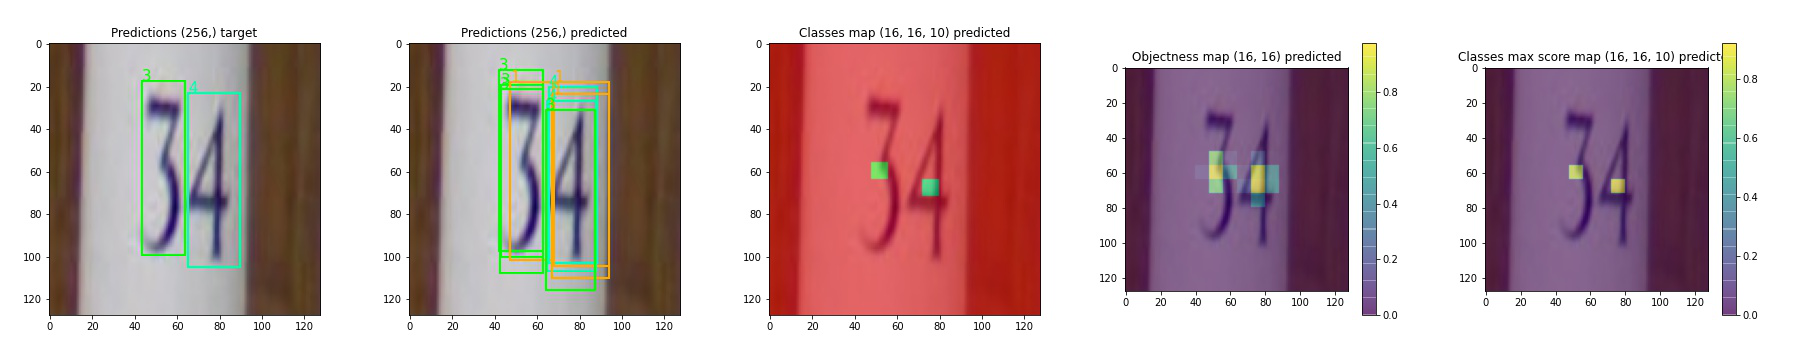

In [55]:
# select index of image in batch
idx = 10
target=dict(
    objectness=targets[f'{fm}/objectness'][idx],
    boxes_shape_map=targets[f'{fm}/box_shape'][idx],
    classes_map=targets[f'{fm}/classes'][idx],
)

predicted=dict(
    objectness=predictions[f'{fm}/objectness'][idx],
    boxes_shape_map=predictions[f'{fm}/box_shape'][idx],
    classes_map=predictions[f'{fm}/classes'][idx],
)

render = plotting.draw_compares(    
    target=target,
    predicted=predicted,
    draw_fns=[
        plotting.draw_boxes, 
        plotting.draw_classes_map,
        plotting.draw_objectness_map,
        plotting.draw_classes_max_score_map,
    ],
    image=features['image'][idx] / 255,
    score_threshold=0.4,
)
render

# Export model to tflite
Conversion is done with:
```python
    converter = from_keras_model(model)
    converter.experimental_new_converter = True
    converter.experimental_new_quantizer = True
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
```

In [60]:
# creates two versions of the model:  
#  - models/quantized-model.tflite
#  - models/quantized-model-quantized.tflite (for this representative dataset is used to accumulate stats)

exported_model, tflite_models_paths = builder.convert_to_tflite(    
    quantized_model, 
    save_path="models/quantized-model.tflite", 
    export_batch_size = 1,
    raw_dataset = test_raw_dataset,  # dataset to the test the stats between 
    num_dataset_samples = 32, # representative dataset number of samples
    num_test_steps = 16, # number of images used to test output statistics
    merge_feature_maps=True,  # merge FPN feature maps into single tensor of shape [1, num_anchors, num_outputs]
    postprocess_outputs=True,  # apply post processing on head outputs e.g. decode box coordinates to [height, width, y_center, x_center]
    convert_quantized_model=False
)

INFO:tensorflow:Preparing dataset for export of quantized model
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness/Identity_2:0", shape=(1, 256), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape/Identity_2:0", shape=(1, 256, 4), dtype=float32)
INFO:tensorflow:- classes              - Tensor("classes/Identity_2:0", shape=(1, 256, 10), dtype=float32)
INFO:tensorflow:Exporting model
INFO:tensorflow:Converting model to tflite format 
INFO:tensorflow:Building TFLite model from Keras Model using optimizations: [<Optimize.DEFAULT: 'DEFAULT'>]
INFO:tensorflow:Model converted successfully 
INFO:tensorflow:Testing tflite model for N=1 iterations ..


Input details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'image',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 128, 128,   3], dtype=int32),
  'shape_signature': array([  1, 128, 128,   3], dtype=int32),
  'sparsity_parameters': {}}
Output details:
{ 'dtype': <class 'numpy.float32'>,
  'index': 184,
  'name': 'export/box_shape/output',
  'quantization': (0.0, 0),
  'quantization_parameters': { 'quantized_dimension': 0,
                               'scales': array([], dtype=float32),
                               'zero_points': array([], dtype=int32)},
  'shape': array([  1, 256,   4], dtype=int32),
  'shape_signature': array([  1, 256,   4], dtype=int32),
  'sparsity_parameters': {}}
{ 'dtype': <class 'numpy.float32'>,
  'index': 192,
  'name': 'export/classes/output'

INFO:tensorflow:Test finished in 1.507886 seconds
INFO:tensorflow:Model saved to models/quantized-model.tflite
INFO:tensorflow:Converting quantized model


RuntimeError: ignored

In [0]:
exported_model, tflite_models_paths 

(<tensorflow.python.keras.engine.training.Model at 0x7fed947c2e10>,
 [PosixPath('models/quantized-model.tflite'),
  PosixPath('models/quantized-model.quantized.tflite')])

# Create box-predictor from converted model

In [57]:
box_detector = builder.as_box_detector("models/quantized-model.h5", is_quantized=True)

INFO:tensorflow:Building quantized model with batch_size = None
INFO:tensorflow:Building graph with quantization enabled
INFO:tensorflow:Input image: (None, 128, 128, 3)
INFO:tensorflow:Processing backbone: <keras_detection.backbones.mobilenetv2_customized.MobileNetV2Backbone object at 0x7f07f266b5c0>
INFO:tensorflow:Running quantization for model backbone: mobilenetv2_1.00_128
INFO:tensorflow:Processing feature maps for tasks: ['objectness', 'box_shape', 'classes']
INFO:tensorflow: Processing feature map (fm16x16)
INFO:tensorflow:Running quantization for head: 'fm16x16/objectness'
INFO:tensorflow:Running quantization for head: 'fm16x16/box_shape'
INFO:tensorflow:Running quantization for head: 'fm16x16/classes'
INFO:tensorflow:Merging feature maps
INFO:tensorflow:Export outputs
INFO:tensorflow:- objectness           - Tensor("objectness/Identity_1:0", shape=(None, 256), dtype=float32)
INFO:tensorflow:- box_shape            - Tensor("box_shape/Identity_1:0", shape=(None, 256, 4), dtype=

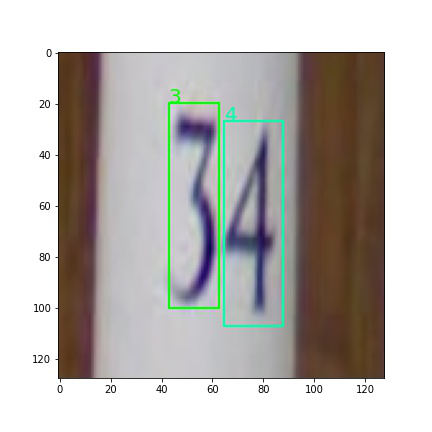

In [58]:
predictions = box_detector.predict(features['image'])
predictions[idx].draw(image=features['image'][idx].numpy(), fontsize=20)

INFO:tensorflow:Building box predictor for TFLite model


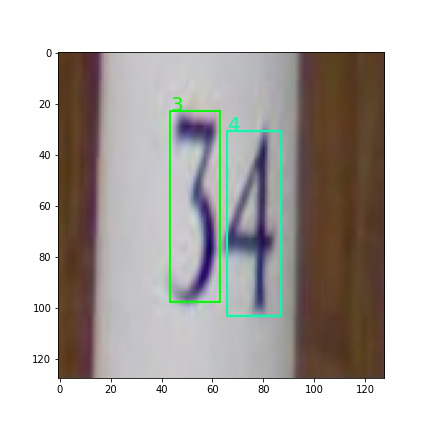

In [59]:
# prediction from integer quantized model will take a while on the GPU
tflite_box_detector =  builder.as_box_detector("models/quantized-model.tflite")
predictions = tflite_box_detector.predict(features['image'])
predictions[idx].draw(image=features['image'][idx].numpy(), fontsize=20)

In [0]:
# # load model converted using representative dataset
# tflite_box_detector =  builder.as_box_detector("models/quantized-model.quantized.tflite")
# predictions = tflite_box_detector.predict(features['image'])
# predictions[idx].draw(image=features['image'][idx].numpy(), fontsize=20)